## Classification Problem

The given database can be used to train a model to guess whether a given case was dismissed or not.
This problem is a binary classification problem where it will output a 1 if the case was dismissed and 0 if it wasn't.

We use the scikit learn and seaborn libraries, which need to be installed.
We use three different models and analyse their performance by the end - DecisionTreeClassifier, RandomForestClassifier and KNeighborsClassifier.

In [225]:
# Libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Encoder
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Evaluation
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, confusion_matrix

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

We use our generated `mixed_sample.csv` file and read it into `df`. It has 1.35 millions rows and after preprocessing it should be enough data to traain the model. Along with that we also read key csv files.

In [226]:
df = pd.read_csv("../cases/mixed_sample.csv")
df.head()

,Unnamed: 0,ddl_case_id,year,state_code,dist_code,court_no,cino,judge_position,female_defendant,female_petitioner,female_adv_def,female_adv_pet,type_name,purpose_name,disp_name,date_of_filing,date_of_decision,date_first_list,date_last_list,date_next_list
0,0,01-01-01-201908000172010,2010,1,1,1,MHNB030000482010,chief judicial magistrate,0 male,-9998 unclear,-9999,0,1429.0,4946.0,25,2010-01-20,2012-10-19,2010-04-20,2012-09-13,2012-10-19
1,1,01-01-01-201908000292010,2010,1,1,1,MHNB030001902010,chief judicial magistrate,0 male,1 female,0,1,1429.0,3006.0,30,2010-02-25,2010-12-01,2010-03-18,2010-11-29,2010-12-01
2,2,01-01-01-201908000602010,2010,1,1,1,MHNB030004262010,chief judicial magistrate,-9998 unclear,0 male,-9998,1,1429.0,509.0,25,2010-05-06,2010-05-26,2010-05-10,2010-05-25,2010-05-26
3,3,01-01-01-201908000742010,2010,1,1,1,MHNB030005682010,chief judicial magistrate,-9998 unclear,0 male,-9999,0,1429.0,2237.0,30,2010-05-29,2013-04-29,2010-06-17,2013-04-12,2013-04-29
4,4,01-01-01-201908001032010,2010,1,1,1,MHNB030006862010,chief judicial magistrate,0 male,1 female,-9999,-9998,1429.0,4882.0,25,2010-07-08,2010-11-20,2010-08-10,2010-10-30,2010-11-20


In [227]:
state_frame = pd.read_csv("../keys/cases_state_key.csv")[['year', 'state_code', 'state_name']]
district_frame = pd.read_csv("../keys/cases_district_key.csv")[['year', 'state_code', 'dist_code', 'district_name']]
disp_frame = pd.read_csv("../keys/disp_name_key.csv")[['year', 'disp_name', 'disp_name_s']]
type_frame = pd.read_csv("../keys/type_name_key.csv")

Now we create `df_merged` which has all required columns.

In [228]:
df_merged = pd.merge(df, state_frame, on=['year','state_code'], how='left')
df_merged = pd.merge(df_merged, district_frame, on=['year', 'state_code', 'dist_code'], how='left')
df_merged = pd.merge(df_merged, disp_frame, on=['disp_name', 'year'], how='left')
df_merged = pd.merge(df_merged, type_frame, on=['type_name', 'year'], how='left')

## Preprocessing

Our dataframe includes several missing or `NaN` values. To train the model we need to remove these.
We do this by encoding all bad values as `np.NaN`.

First, since `disp_name_s` stores the disposition information which we need for the `y` value of the classification problem, 
any rows with `disposition var missing` should be removed. 

At the same time we encode `dismissed` as 1 and everything else as 0.

In [229]:
df_merged.disp_name_s = [np.NaN if row == "disposition var missing" else 1 if row == "dismissed" else 0 for row in df_merged.disp_name_s]

Now we clean the gender columns for `defendant` and `petitioner`.

In [230]:
def clean_gender_1(row):
    if row == '0 male' or row == '0 nonfemale':
        row = 0
    elif row == '1 female':
        row = 1
    else:
        row = np.NaN

    return row

df_merged.female_defendant = [clean_gender_1(row) for row in df_merged.female_defendant]
df_merged.female_petitioner = [clean_gender_1(row) for row in df_merged.female_petitioner]

Next we have to deal with `datetime` columns. We do this by first converting them into `pandas.Datetime` series.

Then we split the `Datetime` objects into 3 columns - `Day, Month, Year` to turn them into numerical data.

In [231]:
df_merged.date_of_decision = pd.to_datetime(df_merged.date_of_decision, errors='coerce')
df_merged.date_of_filing = pd.to_datetime(df_merged.date_of_filing, errors='coerce')

In [232]:
df_merged['filing_year'] = df_merged.date_of_filing.dt.year
df_merged['filing_month'] = df_merged.date_of_filing.dt.month
df_merged['filing_day'] = df_merged.date_of_filing.dt.day
df_merged['decision_year'] = df_merged.date_of_decision.dt.year
df_merged['decision_month'] = df_merged.date_of_decision.dt.month
df_merged['decision_day'] = df_merged.date_of_decision.dt.day
df_merged['duration'] = (df_merged.date_of_decision - df_merged.date_of_filing).dt.days

Finally,  we check if a column has too many `NaN` values. Since `district_name` has too many `NaN` values, we drop the column from the model. This is because the file `district-key.csv` doesn't contain data for most years.

In [233]:
df_merged.isna().sum()

Unnamed: 0                 0
ddl_case_id                0
year                       0
state_code                 0
dist_code                  0
court_no                   0
cino                       0
judge_position             0
female_defendant      281268
female_petitioner     646725
female_adv_def             0
female_adv_pet             0
type_name                  2
purpose_name           47465
disp_name                  0
date_of_filing             0
date_of_decision      308418
date_first_list        56103
date_last_list          9851
date_next_list         33282
state_name                 0
district_name        1198791
disp_name_s           311983
type_name_s                2
count                      0
filing_year                0
filing_month               0
filing_day                 0
decision_year         308418
decision_month        308418
decision_day          308418
duration              308418
dtype: int64

Now we select the features for the model. 

There are two types of columns - `numerical` and `categorical`. Most models only work on numerical data so we need to encode 
caategorical data to a number.

In [235]:
columns=['year', 'state_name', 'female_defendant', 'female_petitioner', 'judge_position', 'duration', 'type_name_s',
        'filing_year', 'filing_month', 'filing_day', 'decision_year', 'decision_month', 'decision_day', 'disp_name_s']

numerical_columns = ['year', 'duration', 'filing_year', 'filing_month', 'filing_day', 
                     'decision_year', 'decision_month', 'decision_day']

categorical_columns = ['state_name', 'judge_position', 'female_defendant', 'female_petitioner', 'type_name_s']
df_merged = df_merged[columns]

We define a pipeline for preprocessing the numeric data using `SimpleImputer` and `StandardScaler` classes.


In [236]:
numeric_pipeline = Pipeline(
    steps=[("impute", SimpleImputer(strategy="mean")), 
           ("scale", StandardScaler())]
)

full_processor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_pipeline, numerical_columns)
    ]
)

In [237]:
df_merged.dropna(inplace=True)
df_merged.shape

/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


(380335, 14)

Hence we are left with `380337` rows of data after dropping the `NaN` value rows. We have 12 features for the model.

In [238]:
df_merged.isna().sum()

year                 0
state_name           0
female_defendant     0
female_petitioner    0
judge_position       0
duration             0
type_name_s          0
filing_year          0
filing_month         0
filing_day           0
decision_year        0
decision_month       0
decision_day         0
disp_name_s          0
dtype: int64

There are thus no NaN values. We can proceed to encoding the categorical data in columns `state_name, judge_position`

In [242]:
le_state = LabelEncoder()
df_merged.state_name = le_state.fit_transform(df_merged.state_name)

In [243]:
le_judge = LabelEncoder()
df_merged.judge_position = le_judge.fit_transform(df_merged.judge_position)

In [244]:
le_type = LabelEncoder()
df_merged.type_name_s = le_type.fit_transform(df_merged.type_name_s)

In [246]:
df_merged

,year,state_name,female_defendant,female_petitioner,judge_position,duration,type_name_s,filing_year,filing_month,filing_day,decision_year,decision_month,decision_day,disp_name_s
1,2010,18,0.0,1.0,102,279.0,1125,2010,2,25,2010.0,12.0,1.0,0.0
4,2010,18,0.0,1.0,102,135.0,1125,2010,7,8,2010.0,11.0,20.0,0.0
5,2010,18,0.0,1.0,102,1758.0,1125,2010,10,18,2015.0,8.0,11.0,0.0
7,2010,18,0.0,0.0,102,9.0,1125,2010,7,6,2010.0,7.0,15.0,0.0
8,2010,18,0.0,0.0,102,14.0,3058,2010,3,15,2010.0,3.0,29.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1349987,2018,5,0.0,0.0,292,0.0,3300,2018,12,21,2018.0,12.0,21.0,0.0
1349994,2018,5,1.0,1.0,292,210.0,631,2018,9,27,2019.0,4.0,25.0,0.0
1349996,2018,16,0.0,1.0,102,281.0,112,2018,6,19,2019.0,3.0,27.0,0.0
1349998,2018,16,0.0,1.0,102,376.0,812,2018,4,19,2019.0,4.0,30.0,0.0


## Pipeline and Splitting

Now we run the data through the pipeline, add the categoric features back and split the data in the ratio of 40% : 60%.

In [247]:
X = df_merged.drop(['disp_name_s'], axis = 1)
y = df_merged.disp_name_s
X_processed = full_processor.fit_transform(X)
X = pd.DataFrame(X_processed)
X['female_defendant'] = df_merged.female_defendant.to_list()
X['female_petitioner'] = df_merged.female_petitioner.to_list()
X['state_name'] = df_merged.state_name.to_list()
X['judge_position'] = df_merged.judge_position.to_list()
X['type_name_s'] = df_merged.type_name_s.to_list()
X.rename(columns={
    0:"Zero", 1:"One", 2:"Two", 3:"Three", 4:"Four", 5:"Five", 6:"Six", 7:"Seven"
}, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.4)

## Model fitting and validation

We define a function below to validate the model. Next we define a fucntion which fits and tests the given model.

We will be using these functions with several models to discuss their performance on the given data.

In [248]:
def evaluation(y, y_hat, title = 'Confusion Matrix'):
    cm = confusion_matrix(y, y_hat)
    precision = precision_score(y, y_hat)
    recall = recall_score(y, y_hat)
    accuracy = accuracy_score(y,y_hat)
    f1 = f1_score(y,y_hat)
    print('Recall: ', recall)
    print('Accuracy: ', accuracy)
    print('Precision: ', precision)
    print('F1: ', f1)
    sns.heatmap(cm,  cmap= 'PuBu', annot=True, fmt='g', annot_kws=    {'size':20})
    plt.xlabel('predicted', fontsize=18)
    plt.ylabel('actual', fontsize=18)
    plt.title(title, fontsize=18)
    
    plt.show();
    
def RunModel(model):
    model.fit(X_train, y_train)
    y_val = model.predict(X_test)
    print(evaluation(y_test, y_val, title='testing set'))
    y_predicted = model.predict(X)
    print(evaluation(y, y_predicted, title='full dataset'))

Recall:  0.19559966050793237
Accuracy:  0.8094180130674274
Precision:  0.5792730085073473
F1:  0.2924496071062522


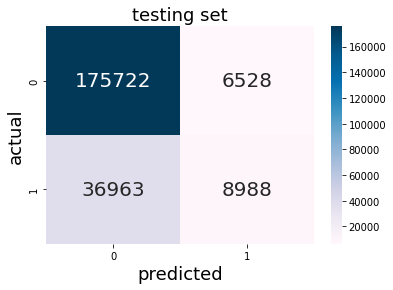

None
Recall:  0.21589279662121647
Accuracy:  0.8167010661653542
Precision:  0.6339521531100478
F1:  0.3220957029920555


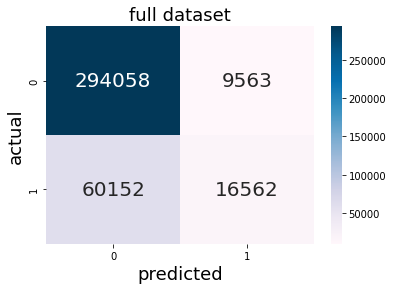

None


In [252]:
RunModel(xgb.XGBClassifier())

Recall:  0.37986115644926116
Accuracy:  0.7345673331843419
Precision:  0.3524055641921221
F1:  0.36561865063572185


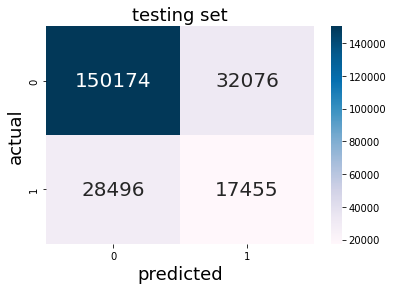

None
Recall:  0.6284120238809083
Accuracy:  0.8407141073001433
Precision:  0.6004683374022222
F1:  0.614122472897744


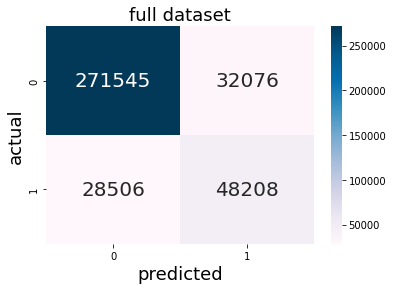

None


In [249]:
RunModel(DecisionTreeClassifier(random_state=0))

Recall:  0.1433701116406607
Accuracy:  0.8060876157422623
Precision:  0.5740676193795747
F1:  0.22943911400560713


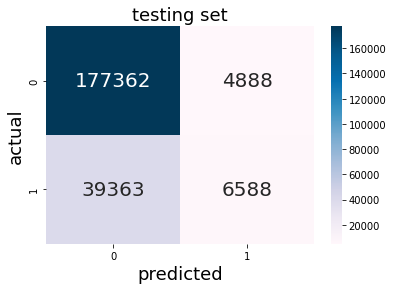

None
Recall:  0.4867429673853534
Accuracy:  0.8836210183128032
Precision:  0.8842264794335646
F1:  0.6278637666781568


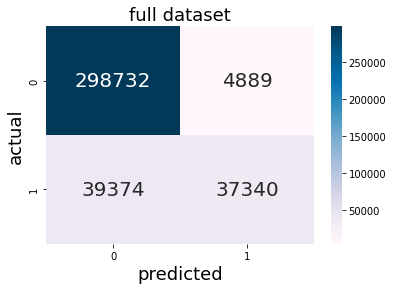

None


In [250]:
RunModel(RandomForestClassifier(random_state=0))

Recall:  0.30351896585493243
Accuracy:  0.7913549896801504
Precision:  0.4718838814453918
F1:  0.36942270253089116


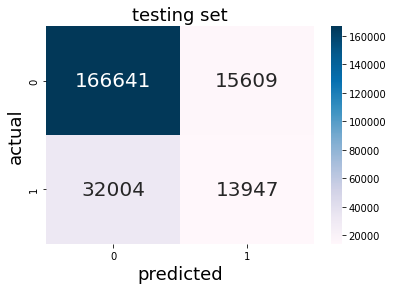

None
Recall:  0.364561879187632
Accuracy:  0.8149710123969658
Precision:  0.5639303934022947
F1:  0.4428416477313213


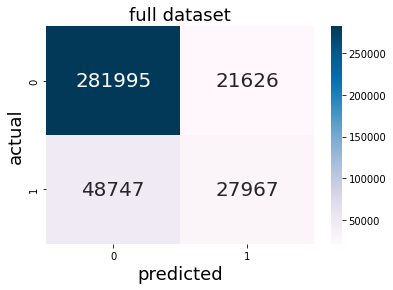

None


In [251]:
RunModel(KNeighborsClassifier())

Out of the 4 models, most of them have around 80% accuracy rate. `RandomForests` and `KNeighbors` both seem to be promising with decent F1 scores and decent test set accuracies.

To further improve upon this model, we could look at the following:
- feature selection
- cyclical encoding of features such as month and day
- hyperparametrising models
- More models such as Naive-Bayes and LogisticRegression